# 1 Problem formulation

The problem I am trying to solve is to predict whether a hum or whistle audio file is an interpretation of a segment of the Harry Potter theme or of the Imperial March. Unlike the original songs, hums and whistles of songs vary between interpreters and between interpretations by a single interpreter. For instance, one interpreter may whistle an octave above another or the same interpreter may hum different versions of the melody, such as finishing a line on a root note versus a fifth, when interpreting the same song more than once. As such, there is a lack of invariance in the audio signal of song interpretations. A machine learning solution to this problem should consider the features of the audio files which vary between songs and ignore features which vary between interpretations and interpreters. A solution to this problem could form the basis of a system which tells users the name of a song, simply by whistling or humming the melody. Such a system would be similar to products like 'Shazam', but could be used without the original song's audio file.

# 2 Machine Learning pipeline

__Input:__

The inputs of my pipeline are raw audio files from the MLEnd hums and whistles data set, consisting of a short segment from either the Harry Potter theme or the Imperial March, as interpreted by a participant in the MLEnd study. For novel applications, the input of the pipeline would be hum or whistle interpretations of either song by a new interpreter.

__Intermediate stages:__

Feature extraction:

The tempo of the song interpretation is estimated from a resampled, time series representation of the input audio file. A spectral flux onset strength envelope is computed for a Mel spectrogram of the audio file and estimated tempo is calculated through onset autocorrelation. The estimated tempo is used in the next stage of the pipeline.

Other features were considered but did not seem as useful for classifying song interpretations (see section 11: appendix).

Classification model:

A linear support vector machine, trained using a subset of all Potter and StarWars files from the MLEnd dataset, will classify the audio file using its estimated global tempo.


__Output:__

The output of my pipeline is a classification for each audio file in the input as the Harry Potter theme or the Imperial March.


# 3 Transformation stage

Global tempo will be extracted from the data and will be estimated using the following transformations:

__Mel Spectrogram:__

Input - raw audio. Output - mel spectrogram.

Audio files are represented as a time series, with sampling rate 22050. A short-time Fourier transform is performed on this time series to give a spectrogram, showing the amplitude of different component frequencies with time in the audio recording. The spectrogram is converted to a mel spectrogram by converting the frequency domain to a mel scale.


__Onset Strength Envelope:__

Input - mel spectrogram. Output - onset strength envelope.

Onset strength is computed from the mel spectrogram using the SuperFlux onset detection algorithm (Böck and Widmer, 2013). This algorithm compares the amplitude of frequencies at time *t* with the amplitude at time *t - lag* to detect positive changes in audio signal energy typically associated with a beat. Note that when assessing amplitude at *t - lag*, a maximum filter is applied across the frequency domain to track the trajectory of the audio signal more effectively. The resulting time series for onset strength is then used to estimate tempo.


__Estimating Tempo:__

Input - onset strength envelope. Output - estimated global tempo.

Tempo is estimated using the auto-correlation of onset strength. The lag of the largest auto-correlation peaks are analysed to estimate the periodicity, and hence tempo, of the audio signal.

# 4 Modelling

__Support Vector Machine:__

A linear support vector machine (SVM) will be implemented to classify interpretations based upon their estimated global tempo. The SVM will learn a decision boundary for tempo, i.e. a single value for tempo, above which the interpretation will be classified as either Potter or Starwars and below which the interpretation will be classified as the other. The Harry Potter theme is the faster of the two original songs, so it is expected that interpretations with tempo above the decision boundary will be classified as Potter.

__K-nearest neighbour:__

The K-nearest-neighbour classifier will predict that an interpretation is of the Harry Potter theme if the majority of training interpretations with closest estimated tempo, to that of the test interpretation, are the Harry Potter theme. Otherwise, the model will predict that the interpretation is of the Imperial March.

__Naive Bayes Classifier:__

A naive Bayes classifier will be trained on the global tempo data to predict songs. The distribution of tempos for each song are assumed to be Gaussian, which is a fair assumption given that the tempo of interpretations is likely to be centered on the true song tempo with some level of variation for slower or faster interpretations. Priors for each class will be generated from the training dataset and will be close to 0.5 as there are a near equal number of interpretations of Potter and StarWars in the training set.

# 5 Methodology

For each model the following training and validation procedure will be carried out:

Models will be trained and validated using a subset of my original dataset. My original dataset, consisting of all Potter and StarWars hums and whistles, will be separated into a training set and a test set. 100 participants (out of 209) will be randomly selected and their audio files will be used for training and validation. This is to ensure a relatively equal number of interpretations for each song in the training and test sets. The remaining 109 participants' data will be used as test data. The training dataset will further be divided into training and validation subsets, with a 70/30 split, through random selection of audio files.

This training and validation procedure will be repeated for each candidate value of K in the K-nearest neighbour model. Default parameters (from the sklearn library) are used for the linear support vector machine and naive bayes classifier during validation. Regularisation is not used for the support vector machine and priors for the naive bayes classifier are generated from the split of Potter to StarWars in the training data.

Accuracy will be used as a quality metric for model performance during validation since I am interested in how often the model makes a correct prediction. There is no need to value the correct prediction of one class more than the other as correctly predicting each song is equally important.

To investigate whether prediction of one song is better than the other I will generate confusion matrices for each model. The percentage of correct predictions for actual Potter or StarWars interpretations (recall) will be used as a measure to compare how good the model is at predicting each song. For the K-nearest neighbour model, only the confusion matrix for the selected value of K will be shown.

The model with highest validation accuracy will be selected for use in the final pipeline and trained using the entire training dataset (all data from the selected 100 participants). The test accuracy and confusion matrix of the final model will then be calculated for the test dataset.

# 6 Dataset

The dataset I will use to train and validate my models is a subset of the MLEnd dataset using only Potter and StarWars interpretations from 100 randomly sampled participants. Data from these 100 participants will be randomly split into training and validation sets.

## Import Data

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
from tqdm import tqdm

import librosa
import librosa.display

import re

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sample_path = '/content/drive/MyDrive/Data/MLEnd/all_data/*.wav'

files = glob.glob(sample_path)

In [ ]:
MLEND_table = [] 
problem_names = []

for file in files:
  file_name = file.split('/')[-1]

  # ppt ID
  find_ID = re.match('S[0-9]{1,3}', file_name)
  if find_ID:
    ppt_ID = find_ID.group(0)[1:]
  else:
    ppt_ID = 'unknown'
    problem_names.append(file_name)

  # interpretation type
  hum = re.search('hum', file_name, re.IGNORECASE)
  whistle = re.search('whi', file_name, re.IGNORECASE)
  if hum:
    interpret_type = 'hum'
  elif whistle:
    interpret_type = 'whistle'
  else:
    interpret_type = 'unknown'
    problem_names.append(file_name)

  # interpretation number
  find_num = re.search('[^S0-9][0-9]', file_name)
  if find_num:
    interpret_num = find_num.group(0)[1]
  else:
    interpret_num = 'unknown'
    problem_names.append(file_name)

  # song
  potter = re.search('pot', file_name, re.IGNORECASE)
  starwars = re.search('sta', file_name, re.IGNORECASE)
  imperial = re.search('imp', file_name, re.IGNORECASE)
  if potter:
    song = 'Potter'
  elif (bool(starwars) | bool(imperial)):
    song = 'StarWars'
  else:
    song = 'unknown'
    problem_names.append(file_name)
  
  MLEND_table.append([file_name, ppt_ID, interpret_type, interpret_num, song])

MLEND_table[:4]

[['S1_hum_2_Potter.wav', '1', 'hum', '2', 'Potter'],
 ['S1_whistle_2_Potter.wav', '1', 'whistle', '2', 'Potter'],
 ['S2_hum_2_Potter.wav', '2', 'hum', '2', 'Potter'],
 ['S2_whistle_2_Potter.wav', '2', 'whistle', '2', 'Potter']]

In [ ]:
MLEND_df = pd.DataFrame(MLEND_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 
MLEND_df

,participant,interpretation,number,song
file_id,,,,
S1_hum_2_Potter.wav,1,hum,2,Potter
S1_whistle_2_Potter.wav,1,whistle,2,Potter
S2_hum_2_Potter.wav,2,hum,2,Potter
S2_whistle_2_Potter.wav,2,whistle,2,Potter
S3_hum_1_Potter.wav,3,hum,1,Potter
...,...,...,...,...
S219_hum_4_StarWars.wav,219,hum,4,StarWars
S221_hum_1_StartWars.wav,221,hum,1,StarWars
S221_hum_2_StarWars.wav,221,hum,2,StarWars


## Split Dataset into Training and Test

In [ ]:
MLEND_df.participant = pd.to_numeric(MLEND_df.participant)
selection = np.random.choice(np.unique(MLEND_df.participant), 100, replace=False)
condition = [(i in selection) for i in MLEND_df.participant]
use_df = MLEND_df.loc[condition]
use_files = []
for file in files:
  file_name = file.split('/')[-1]
  files_cond = any(use_df.index == file_name)
  if files_cond:
    use_files.append(file)

len(use_files)

394

## Visualising the Dataset

### Example Resampled Time Series Generated from Audio File

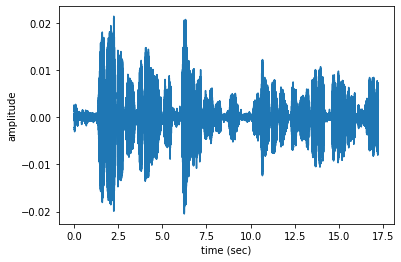

In [ ]:
fs = None
x, fs = librosa.load(files[3],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()

The above graph shows amplitude over time for a single audio file.

### Example Mel Spectrogram

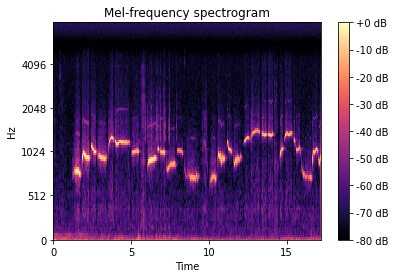

In [ ]:
S = librosa.feature.melspectrogram(y=x, sr=fs)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=fs,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
_ = ax.set(title='Mel-frequency spectrogram')

The above graph shows how frequency changes over time for a single audio file. The loudness (dB) of each frequency at a given time is shown by colour. The y axis shown is mel scale.

### Example Onset Strength Envelope

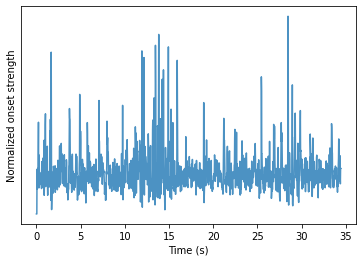

In [ ]:
onset_env = librosa.onset.onset_strength(y=x, sr=fs)
D = np.abs(librosa.stft(x))
times = librosa.times_like(D)

fig, ax = plt.subplots()
ax.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8,
           label='Mean (mel)')
_ = ax.set(ylabel='Normalized onset strength', yticks=[])
_ = ax.set(xlabel = 'Time (s)')

The above graph shows normalised onset strength (calculated using the SuperFlux algorithm) with time in a single audio file. Peaks represent high onset strength and times at which it is likely that a beat occurs.

## Estimating Tempo from the Training Dataset

In [ ]:
def get_tempo(files, labels_file):
  X,y,hum =[],[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = labels_file.loc[fileID, 'song']=='Potter'

    x, sr = librosa.load(file)
    hop_length = 128
    oenv = librosa.onset.onset_strength(y=x, sr=sr, hop_length=hop_length)
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                           hop_length=hop_length)[0]

    xi = [tempo]
    X.append(xi)
    y.append(yi)
    hum.append(humi)

  return np.array(X),np.array(y),np.array(hum)

X, y, hum = get_tempo(use_files, use_df)

100%|██████████| 394/394 [14:04<00:00,  2.14s/it]


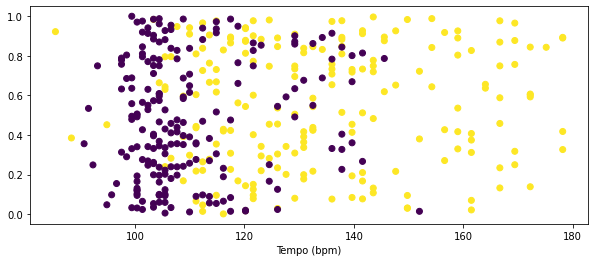

In [ ]:
plt.figure(figsize=(10,4))
_ = plt.scatter(X[:, 0], np.random.uniform(0,1,X.shape[0]), c=y)    # y values randomised between 0 and 1 for visualisation purposes
_ = plt.xlabel('Tempo (bpm)')

The above graph plots estimated tempo along the x axis and random values on the y axis for visualisation purposes. Each point represents a single audio file from the training dataset. Shown in yellow are Potter interpretations and in purple are StarWars interpretations. Overall StarWars interpretations are slower than Potter interpretations.

# 7 Results

## Train and Validate Models

### Split Training Dataset into Training and Validation Subsets

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)    # change test size
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((275, 1), (119, 1), (275,), (119,))

### Linear Support Vector Machine

In [ ]:
from sklearn import svm

lin_SVC  = svm.SVC(C=1, kernel='linear')
lin_SVC.fit(X_train,y_train)

yt_p = lin_SVC.predict(X_train)
yv_p = lin_SVC.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', lin_SVC.support_vectors_.shape)

Training Accuracy 0.7636363636363637
Validation  Accuracy 0.7899159663865546
The support vectors are (146, 1)


In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_train, y_pred=lin_SVC.predict(X_train))
print('Validation recall for StarWars', conf_matrix[0,0] / np.sum(conf_matrix[0]))
print('Validation recall for Potter', conf_matrix[1,1] / np.sum(conf_matrix[1]))
pd.DataFrame(conf_matrix, columns = ['pred_StarWars', 'pred_Potter'], index = ['StarWars', 'Potter'])

Validation recall for StarWars 0.8235294117647058
Validation recall for Potter 0.7122302158273381


,pred_StarWars,pred_Potter
StarWars,112,24
Potter,40,99


### K-Nearest Neighbour

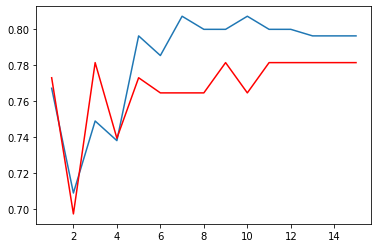

In [ ]:
from sklearn import neighbors

ks = range(1,16)

y_hat_t = dict.fromkeys(ks)
y_hat_v = dict.fromkeys(ks)
accuracy_t = dict.fromkeys(ks)
accuracy_v = dict.fromkeys(ks)
conf_mat_t = dict.fromkeys(ks)
conf_mat_v = dict.fromkeys(ks)

for k in ks:
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_hat_t[k] = knn.predict(X_train)
  y_hat_v[k] = knn.predict(X_val)
  accuracy_t[k] = np.sum(y_train==y_hat_t[k])/len(y_train)
  accuracy_v[k] = np.sum(y_val==y_hat_v[k])/len(y_val)
  conf_mat_t[k] = confusion_matrix(y_true=y_train, y_pred=y_hat_t[k])
  conf_mat_v[k] = confusion_matrix(y_true=y_val, y_pred=y_hat_v[k])


figure, ax = plt.subplots(1, 1)
_ = ax.plot(ks, list(accuracy_t.values()))
_ = ax.plot(ks, list(accuracy_v.values()), c='red')

Validation accuracy for the K-nearest neighbout model seems to stabilise by K = 6. Smaller values of K vary in validation accuracy. Increasing K to 12 only improves accuracy slightly, so K = 6 will be used to reduce the number of neighbours which need to be compared for classification.

Note: the large variation in validation accuracies for small values of k may be partly attributed to some song interpretations sharing the same estimated tempo. This could be rectified by decreasing hop_length when estimating tempo from audio files, but at the cost of more computation.

In [ ]:
print('Training accuracy', accuracy_t[6])
print('Validation accuracy', accuracy_v[6])
print('Validation recall for StarWars', conf_mat_v[6][0,0] / np.sum(conf_mat_v[6][0]))
print('Validation recall for Potter', conf_mat_v[6][1,1] / np.sum(conf_mat_v[6][1]))
pd.DataFrame(conf_mat_v[6], columns = ['pred_StarWars', 'pred_Potter'], index = ['StarWars', 'Potter'])

Training accuracy 0.7854545454545454
Validation accuracy 0.7647058823529411
Validation recall for StarWars 0.7580645161290323
Validation recall for Potter 0.7719298245614035


,pred_StarWars,pred_Potter
StarWars,47,15
Potter,13,44


### Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

yt_p = gnb.predict(X_train)
yv_p = gnb.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.730909090909091
Validation  Accuracy 0.7478991596638656


In [ ]:
conf_matrix = confusion_matrix(y_true=y_train, y_pred=gnb.predict(X_train))
print('Validation recall for StarWars', conf_matrix[0,0] / np.sum(conf_matrix[0]))
print('Validation recall for Potter', conf_matrix[1,1] / np.sum(conf_matrix[1]))
pd.DataFrame(conf_matrix, columns = ['pred_StarWars', 'pred_Potter'], index = ['StarWars', 'Potter'])

Validation recall for StarWars 0.8455882352941176
Validation recall for Potter 0.6187050359712231


,pred_StarWars,pred_Potter
StarWars,115,21
Potter,53,86


### Model Selection

The linear support vector machine had the highest validation accuracy (79.0%) of all models so will be used in the final pipeline.

## Test Final Model

In [ ]:
test_condition = [not (i in selection) for i in MLEND_df.participant]
test_df = MLEND_df.loc[test_condition]
test_files = []
for file in files:
  file_name = file.split('/')[-1]
  files_cond = any(test_df.index == file_name)
  if files_cond:
    test_files.append(file)

len(test_files)

430

### Estimated Tempo for Test Dataset

In [ ]:
X_test, y_test = get_tempo(test_files, test_df)

100%|██████████| 430/430 [15:21<00:00,  2.14s/it]


In [ ]:
lin_SVC.fit(X,y)
ytest_p = lin_SVC.predict(X_test)
print('Test Accuracy', np.mean(ytest_p==y_test))

Test Accuracy 0.7883720930232558


In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=ytest_p)
print('Test recall for StarWars', conf_matrix[0,0] / np.sum(conf_matrix[0]))
print('Test recall for Potter', conf_matrix[1,1] / np.sum(conf_matrix[1]))
pd.DataFrame(conf_matrix, columns = ['pred_StarWars', 'pred_Potter'], index = ['StarWars', 'Potter'])

Test recall for StarWars 0.8837209302325582
Test recall for Potter 0.6930232558139535


,pred_StarWars,pred_Potter
StarWars,190,25
Potter,66,149


## Explaining Results

Three families of model were trained to predict whether audio files were of the Harry Potter theme or of the Imperial March. Of these models, the model with highest validation accuracy was the linear support vector machine, which was selected to be used in the final machine learning pipeline.

The support vector machine model had a 78.8% accuracy at test, suggesting that it is a good predictor of whether audio files are of the Harry Potter theme or Imperial March. The test recall for StarWars was 88.4% compared to 69.3% for Potter, suggesting that the model performs considerably better if given an Imperial March interpretation than when given a Harry Potter theme interpretation to classify.

# 8 Conclusions

The model can reliably predict the song being interpreted, with test accuracy of 78.8%. Although this is true for interpretations of the Harry Potter theme and Imperial March, such reliable prediction may not generalise if my methodology were applied to novel songs. One reason why the results may not generalise to new songs is that the classification of songs is reliant entirely on the tempo of the interpretation. My solution would not be suitable for classifying interpretations of two songs with a similar tempo.

Moreover, the pipeline's reliance on tempo could be problematic for future applications of the model. If a user wanted to know the name of a song quickly by humming the melody, they may be inclined to hum at an increased speed to get to an answer more quickly. This would change the model's song prediction, even though the spectral features of the audio input are identical in the frequency domain, just compressed into a shorter time.

To improve my solution, I would consider incorporating spectral features related to frequency into my model. This could improve the accuracy of the model further and reduce its reliance on tempo.

Moreover, I would consider improving the model's recall for Harry Potter theme interpretations. The model's test recall was much higher for StarWars (88.4%) than it was for Potter (69.3%). The class weights for the support vector machine could be altered to improve Potter recall, although this may be at the cost of overall accuracy.

With these limitations in mind, my solution is simple and effective, requiring the extraction of only a single feature from the input audio to classify a song interpretation. The addition of spectral features may not be necessary if an accuracy of ~75% is deemed acceptable.

# 9 References

Böck, S., & Widmer, G. (2013, September). Maximum filter vibrato suppression for onset detection. In Proc. of the 16th Int. Conf. on Digital Audio Effects (DAFx). Maynooth, Ireland (Sept 2013) (Vol. 7).

# 10 Appendix: Excluded Features

## Extract Features:

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def getXy(files, labels_file, scale_audio=False, onlySingleDigit=False):
  X,y,hum =[],[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = labels_file.loc[fileID, 'song']=='Potter'
    humi = labels_file.loc[fileID, 'interpretation']=='hum'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)
    hum.append(humi)

  return np.array(X),np.array(y),np.array(hum)

X_basic, y_basic, hum_basic = getXy(use_files, use_df)

100%|██████████| 394/394 [21:54<00:00,  3.34s/it]


## Visualising Features using PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
standardise = scaler.fit(X_basic)
z_scores = standardise.transform(X_basic)

pca = PCA(2)
pp_fit = pca.fit(z_scores)
pp_data = pp_fit.transform(z_scores)

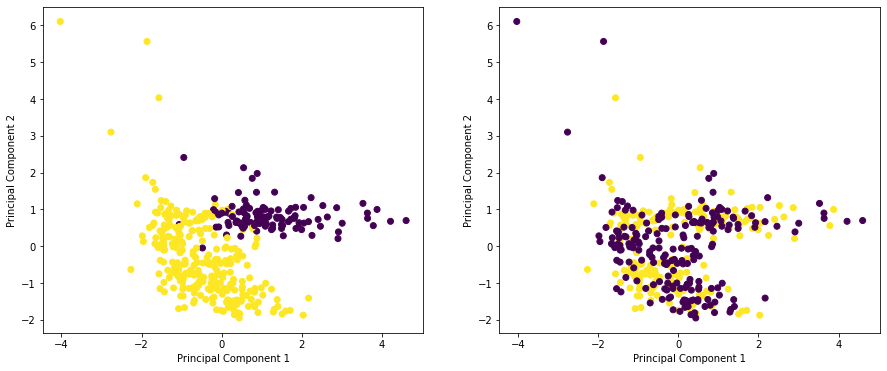

In [ ]:
# Plot 3D scatterplot
fig, [a1,a2] = plt.subplots(1, 2, figsize=(15,6))
a1.scatter(pp_data[:,0],pp_data[:,1],c=hum_basic)
a2.scatter(pp_data[:,0],pp_data[:,1],c=y_basic)
a1.set_xlabel('Principal Component 1')
a1.set_ylabel('Principal Component 2')
a2.set_xlabel('Principal Component 1')
a2.set_ylabel('Principal Component 2')
plt.show()

Power, mean pitch, pitch standard deviation and fraction of audio which is voiced were extracted as possible features for classifying Potter and StarWars audio files. Whilst they seem to be useful for distinguishing hums from whistles (left), these features are not so useful for distinguishing Potter from StarWars (right).